Part 0: downloading packages and data

In [1]:
pip install pyblp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 868 kB 8.5 MB/s 


In [2]:
import pyblp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pyblp.options.digits = 2
pyblp.options.verbose = False

In [32]:
# loading data for cereals market from Aviv Nevo's paper
# we have 24 goods in each of 94 markets; overall 24*94=2256 observations
product_data=pd.read_csv(pyblp.data.NEVO_PRODUCTS_LOCATION)
product_data.head()
# to download the data in Excel format, type
# product_data.to_excel("data_cereals.xlsx")

,market_ids,city_ids,quarter,product_ids,firm_ids,brand_ids,shares,prices,sugar,mushy,...,demand_instruments10,demand_instruments11,demand_instruments12,demand_instruments13,demand_instruments14,demand_instruments15,demand_instruments16,demand_instruments17,demand_instruments18,demand_instruments19
0,C01Q1,1,1,F1B04,1,4,0.012417,0.072088,2,1,...,2.116358,-0.154708,-0.005796,0.014538,0.126244,0.067345,0.068423,0.034800,0.126346,0.035484
1,C01Q1,1,1,F1B06,1,6,0.007809,0.114178,18,1,...,-7.374091,-0.576412,0.012991,0.076143,0.029736,0.087867,0.110501,0.087784,0.049872,0.072579
2,C01Q1,1,1,F1B07,1,7,0.012995,0.132391,4,1,...,2.187872,-0.207346,0.003509,0.091781,0.163773,0.111881,0.108226,0.086439,0.122347,0.101842
3,C01Q1,1,1,F1B09,1,9,0.005770,0.130344,3,0,...,2.704576,0.040748,-0.003724,0.094732,0.135274,0.088090,0.101767,0.101777,0.110741,0.104332
4,C01Q1,1,1,F1B11,1,11,0.017934,0.154823,12,0,...,1.261242,0.034836,-0.000568,0.102451,0.130640,0.084818,0.101075,0.125169,0.133464,0.121111


Important to remember: reserved names in pyblp


1.   Variables named *prices*, *shares* and *market_ids* are *always* treated as prices, shares, and market_ids, respectively. You cannot have you prices, shares and market_ids variables named differently. You must have such variables in your data, otherwise pyblp will return an error.
2.   Variables named *demand_instruments0*, *demand_instruments1*, *demand_instruments2*, etc are always treated as (exogenous) instruments. You cannot have you instruments named differently. You must have at least one instrument in your data, otherwise pyblp will return an error.



Part 1. Plain Logit

In [29]:
# plain logit formulation
# we specify an equation for deltas
#delta = ...
logit_formulation=pyblp.Formulation('1 + sugar + mushy + prices') #constant is included, to exclude it write '0 + ...'
#to include a function of a variable write I(...)
#logit_formulation=pyblp.Formulation('1 + sugar + I(sugar**2) + mushy + prices') 

#defining an estimation problem
#a "problem" is a combination of formulation and data
problem=pyblp.Problem(logit_formulation, product_data)

In [30]:
problem

Dimensions:
 T    N     F    K1    MD 
---  ----  ---  ----  ----
94   2256   5    4     23 

Formulations:
     Column Indices:         0     1      2      3   
--------------------------  ---  -----  -----  ------
X1: Linear Characteristics   1   sugar  mushy  prices

In [31]:
#getting plain logit results
logit_results=problem.solve() #empty parentheses signals to pyblp that we want plain logit
logit_results

Problem Results Summary:
GMM   Objective  Clipped  Weighting Matrix  Covariance Matrix
Step    Value    Shares   Condition Number  Condition Number 
----  ---------  -------  ----------------  -----------------
 2    +2.0E+02      0         +3.2E+08          +1.6E+05     

Cumulative Statistics:
Computation   Objective 
   Time      Evaluations
-----------  -----------
 00:00:00         2     

Beta Estimates (Robust SEs in Parentheses):
    1         sugar       mushy       prices  
----------  ----------  ----------  ----------
 -2.9E+00    +4.8E-02    +7.8E-02    -1.1E+01 
(+1.1E-01)  (+4.2E-03)  (+5.1E-02)  (+8.4E-01)

How to interpret the coefficients $\beta$ before our $X$'es (observed good characteristics)?



1. Short answer which is OK: betas measure by how much utility will change if the corresponding characteric changes by 1 unit. For example, $\beta_{sugar}$ is how many *utils* a unit of sugar gives.
2. Long but better answer:  here, a coefficients measure not really $\beta$ but $\beta/\sigma$
where $\sigma$ is the scale parameter of the individual taste shock's $ɛ$ Gumbel distribution (see [here](https://en.wikipedia.org/wiki/Gumbel_distribution); $\sigma$ is proportional to the distribution's standard deviation). So in fact the estimate says by how many times the importance of sugar as factor of utility is greater than the importance of unobserved individual tastes.
Because we cannot in principle identify $\sigma$ from our data, we have set it to 1 from the very start (this does not change any of our economic predictions). We say that we *normalized* $\sigma$ to 1. That is why write just $\beta$ everywhere, but not $\beta/\sigma$. 
In other words, by setting $\sigma$ to 1 we started to measure utility in sigmas. This effectively defines what a *util* means in our model.

How to compute willingness to pay for a characteristic:

Denote the (common) willingness to pay for a unit of sugar by $w_{sugar}$. It can be found from the utility equatity (a consumer is indifferent between simultaneously changing the amount by 1 and price by $w$, and not changing anything). That is, $\beta_{sugar}*1=\alpha*w_{sugar}$ where $\beta_{sugar}$ is the sugar coefficient and $\alpha$ is the absolute value of the price coefficient. Thus, $w_{sugar}=\beta_{sugar}/\alpha$.

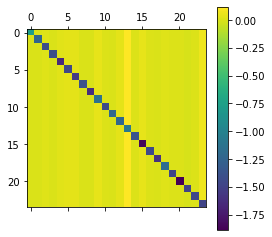

In [9]:
#computing elasticities
elasticities = logit_results.compute_elasticities()
#computing matrix of elasticities in a single market
single_market = product_data['market_ids'] == 'C01Q1'
#elasticities[single_market]
plt.colorbar(plt.matshow(elasticities[single_market]))


In the matrix above, element (i,j) is the elasticity of market share of good i with respect to price of good j.

We see that in each column all elements are the same (excluding the main diagonal); in other words, ignoring the main diagonal, every row in the matrix is the same.
This is exactly what we got in class analytically: in Plain Logit, the cross-elasticity of $s_i$ with respect to $p_j$ ($i\neq j$) at a particular point does *not* depend on $i$. If the price of cereals 1 goes up by 1\%, the market shares of all other cereals will drop by the same percentage! This is a strong a consequence of IIA which is unlikely to hold in practice. So it is a bug of the Plain Logit model.

In [12]:
#mean elasticities across products in each market
#the length of means will be equal to the number of markets
means = logit_results.extract_diagonal_means(elasticities)
means

array([[-1.4041377 ],
       [-1.372442  ],
       [-1.34378504],
       [-1.291206  ],
       [-1.27534328],
       [-1.40173829],
       [-1.331168  ],
       [-1.36595386],
       [-1.29533132],
       [-1.33106487],
       [-1.40566192],
       [-1.35028657],
       [-1.34107885],
       [-1.39483944],
       [-1.33852352],
       [-1.2969514 ],
       [-1.37765831],
       [-1.31262925],
       [-1.2959691 ],
       [-1.33952579],
       [-1.25990519],
       [-1.40978166],
       [-1.1880758 ],
       [-1.25845217],
       [-1.27709336],
       [-1.25953073],
       [-1.30833021],
       [-1.28698441],
       [-1.23870251],
       [-1.27365455],
       [-1.301604  ],
       [-1.42076271],
       [-1.39045795],
       [-1.3387063 ],
       [-1.422533  ],
       [-1.31829344],
       [-1.28113171],
       [-1.36933109],
       [-1.33189419],
       [-1.34360278],
       [-1.36760917],
       [-1.4248397 ],
       [-1.30435418],
       [-1.32909998],
       [-1.38697499],
       [-1

Trying the Naive OLS: tricking pyblp into thinking that price is exogenous

In [15]:
#naively trying OLS without instruments, making price its own instrument
print(product_data.columns.values)
#deleting current instruments
product_data_OLS=product_data.drop(product_data.columns[10:], axis=1)
print(product_data_OLS.columns.values)
#adding a new instrument which is just price itself
product_data_OLS["demand_instruments0"]=product_data_OLS["prices"]
#creating an OLS estimation problem
problem_OLS = pyblp.Problem(logit_formulation, product_data_OLS)
logit_results_OLS = problem_OLS.solve()
logit_results_OLS



['market_ids' 'city_ids' 'quarter' 'product_ids' 'firm_ids' 'brand_ids'
 'shares' 'prices' 'sugar' 'mushy' 'demand_instruments0'
 'demand_instruments1' 'demand_instruments2' 'demand_instruments3'
 'demand_instruments4' 'demand_instruments5' 'demand_instruments6'
 'demand_instruments7' 'demand_instruments8' 'demand_instruments9'
 'demand_instruments10' 'demand_instruments11' 'demand_instruments12'
 'demand_instruments13' 'demand_instruments14' 'demand_instruments15'
 'demand_instruments16' 'demand_instruments17' 'demand_instruments18'
 'demand_instruments19']
['market_ids' 'city_ids' 'quarter' 'product_ids' 'firm_ids' 'brand_ids'
 'shares' 'prices' 'sugar' 'mushy']


Problem Results Summary:
GMM   Objective  Clipped  Weighting Matrix  Covariance Matrix
Step    Value    Shares   Condition Number  Condition Number 
----  ---------  -------  ----------------  -----------------
 2    +1.9E-23      0         +1.4E+05          +1.5E+05     

Cumulative Statistics:
Computation   Objective 
   Time      Evaluations
-----------  -----------
 00:00:00         2     

Beta Estimates (Robust SEs in Parentheses):
    1         sugar       mushy       prices  
----------  ----------  ----------  ----------
 -3.0E+00    +4.6E-02    +5.2E-02    -1.0E+01 
(+1.0E-01)  (+4.2E-03)  (+5.3E-02)  (+8.3E-01)

We see that the OLS price coefficient -1.0E+01 is, as expected, less negative then the IV price coefficient -1.1E+01. Hence, we indeed have the endogeneity of price such that the price and $\xi$ (unobservable quality components) are positively correlated.





Plain Logit with product fixed effects.

Important: if we include product fixed effects, we cannot include any product characteristic that does not depend on the market. Otherwise, we will get collinearity.

In [19]:
#logit with product fixed effects

logit_formulation_fe = pyblp.Formulation('0 + prices', absorb='C(product_ids)')
# for quarter fixed effects, logit_formulation_fe = pyblp.Formulation('1 + sugar + mushy + prices', absorb='C(quarter)')
problem_fe = pyblp.Problem(logit_formulation_fe, product_data)
logit_results_fe = problem_fe.solve()
logit_results_fe

Problem Results Summary:
GMM   Objective  Clipped  Weighting Matrix
Step    Value    Shares   Condition Number
----  ---------  -------  ----------------
 2    +1.9E+02      0         +5.7E+07    

Cumulative Statistics:
Computation   Objective 
   Time      Evaluations
-----------  -----------
 00:00:00         2     

Beta Estimates (Robust SEs in Parentheses):
  prices  
----------
 -3.0E+01 
(+1.0E+00)

Part 2. Nested Logit

In [23]:
def solve_nl(df):
  #nesting_ids is the identity of nest
    groups = df.groupby(['market_ids', 'nesting_ids'])
    #creating a new instrument: number of goods in the nest
    df['demand_instruments20'] = groups['shares'].transform(np.size)
    nl_formulation = pyblp.Formulation('0 + sugar + mushy + prices')
    problem = pyblp.Problem(nl_formulation, df)
    #rho is the parameter which is equal to 1-lambda
    #where lambda is our  nested logit parameter from lectures

    return problem.solve(rho=0.7)
    #Write ``rho= ...'', signals to pyblp that
    #we want to estimate nested logit
    #rho=0.7 means that we want to start our optimization search for rho from 0.7

Case 1: all inside goods in a single nest

In [24]:
#All inside goods in a single nest
#so we have two nests: nest #1 - outside good; nest #2 - all other goods (inside goods)
#this is not the same as plain logit because here we allow for correlation of individual shocks across inside goods
df1 = product_data.copy()
# setting nesting ids such all inside goods are in one nest
df1['nesting_ids'] = 1
nl_results1 = solve_nl(df1)
nl_results1

Problem Results Summary:
GMM   Objective    Projected    Reduced   Clipped  Weighting Matrix  Covariance Matrix
Step    Value    Gradient Norm  Hessian   Shares   Condition Number  Condition Number 
----  ---------  -------------  --------  -------  ----------------  -----------------
 2    +3.4E+02     +0.0E+00     +0.0E+00     0         +2.3E+09          +3.4E+05     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective 
   Time      Converged   Iterations   Evaluations
-----------  ---------  ------------  -----------
 00:00:03       Yes          1             5     

Rho Estimates (Robust SEs in Parentheses):
All Groups
----------
 +9.9E-01 
(+1.4E-02)

Beta Estimates (Robust SEs in Parentheses):
  sugar       mushy       prices  
----------  ----------  ----------
 -2.1E-05    +1.2E-02    -1.0E+00 
(+1.8E-03)  (+1.9E-02)  (+4.8E-01)

We got: $\hat{\rho}\approx 0.99$, hence $\hat{\lambda}\approx 0.01$. $\lambda$ is a measure of independence of ind shocks across goods inside nests. Hence, $\rho$ is a measure of *dependence* of ind shocks inside nests.

*   $0.01\in[0,1]$ so probably our nested structure is not too bad
*   $0.01\approx 0$, so the individual taste shocks are very much correlated across goods inside nests











Case 2: nests are defined accroding to mushiness

In [25]:
#two nests: mushy and non-mushy
df2 = product_data.copy()
df2['nesting_ids'] = df2['mushy']
nl_results2 = solve_nl(df2)
nl_results2

Problem Results Summary:
GMM   Objective    Projected    Reduced   Clipped  Weighting Matrix  Covariance Matrix
Step    Value    Gradient Norm  Hessian   Shares   Condition Number  Condition Number 
----  ---------  -------------  --------  -------  ----------------  -----------------
 2    +4.0E+02     +0.0E+00     +0.0E+00     0         +8.9E+08          +3.6E+05     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective 
   Time      Converged   Iterations   Evaluations
-----------  ---------  ------------  -----------
 00:00:02       Yes          1             5     

Rho Estimates (Robust SEs in Parentheses):
All Groups
----------
 +9.9E-01 
(+2.0E-02)

Beta Estimates (Robust SEs in Parentheses):
  sugar       mushy       prices  
----------  ----------  ----------
 +1.1E-04    -6.4E-01    -4.4E+00 
(+2.1E-03)  (+2.4E-02)  (+5.7E-01)

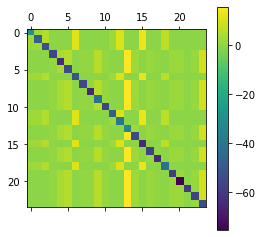

In [26]:
#computing elasticities again
elasticities_nl2 = nl_results2.compute_elasticities()
#computing matrix of elasticities in a single market
single_market = product_data['market_ids'] == 'C01Q1'
#elasticities[single_market]
plt.colorbar(plt.matshow(elasticities_nl2[single_market]))

We see that the rows of this matrix are different so there is no IIA (unlike plain logit)